# Simple Recommendation Model using Neural Network

This is an attempt to use a Neural Network for a **simple** recommendation system. We will recycle some of the stuff from the first iteration. Let's go!

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from matplotlib import pyplot as plt

#### Load the data
We will load the previously (kinda) cleaned dataset, saved in a `parquet` file. This file containes a column `issue_title_clean` with the title of the issue isolated from the rest of the issue comments.

Note that this file is only a subset of the whole dataset, with 10,000 samples only.

In [2]:
# load a subset of the dataset
pr_df = pd.read_parquet("../data/intermediate_data/pr_df_clean_issues.parquet")

# sanity check
assert 'issue_title_clean' in pr_df.columns, "Missing 'issue_title_clean' in the dataset"
pr_df = pr_df[pr_df['issue_title_clean'].notnull()]

print(f"Dataset shape: {pr_df.shape}")
print(f'The column names: {pr_df.columns}')
pr_df.head(3)


Dataset shape: (10000, 14)
The column names: Index(['repo', 'parent_repo', 'child_repo', 'issue_id', 'issue_number',
       'issue', 'text_size', 'usernames', 'users', 'mock_number',
       'issue_title', 'issue_comments', 'issue_title_clean',
       'issue_comments_clean'],
      dtype='object')


,repo,parent_repo,child_repo,issue_id,issue_number,issue,text_size,usernames,users,mock_number,issue_title,issue_comments,issue_title_clean,issue_comments_clean
0,kaisermann/svelte-i18n,kaisermann,svelte-i18n,550510104,40,Title: WIP - v3\nusername_0: \n,2398,"[kaisermann, elbourki]",elbourki,52812,WIP - v3,,WIP v3,
1,material-components/material-components-ios,material-components,material-components-ios,551064006,9444,Title: [AppBar] Fix swipe to go back gesture f...,355,"[jverkoey, bryanoltman]",bryanoltman,38978,[AppBar] Fix swipe to go back gesture for MDCA...,[AppBar] Fix swipe to go back gesture for MDCA...,AppBar Fix swipe to go back gesture for MDCApp...,AppBar Fix swipe to go back gesture for MDCApp...
2,dlang/phobos,dlang,phobos,551980198,7355,"Title: Add initial support for iOS, tvOS and w...",4306,"[wilzbach, etcimon, Geod24, CyberShadow, t...",jacob-carlborg,66742,"Add initial support for iOS, tvOS and watchOS",I've only tested this on a 64 bit iPhone runni...,"Add initial support for iOS, tvOS and watchOS",I've only tested this on a 64 bit iPhone runni...


#### Generate the TF-IDF Matrix

Here we go through the same step as the previous simple recommender system.

In [3]:
# initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words = 'english', max_features = 5000)

# generate the TF-IDF matrix
tfidf_matrix = vectorizer.fit_transform(pr_df['issue_title_clean'])

# let's take a look
print(f'tf-idf matrix shape: {tfidf_matrix.shape}')
print(f'Features: {vectorizer.get_feature_names_out()}')


tf-idf matrix shape: (10000, 5000)
Features: ['00' '01' '02' ... 'zsh' 'ztests' 'ztsurl']


#### Create pairwise training data

In [4]:
# compute cosine similarity matrix
cos_sim_matrix = cosine_similarity(tfidf_matrix)

# generate pairs of indices and similarity scores
pairs = []
for i in range(len(cos_sim_matrix)):
    for j in range(i+1, len(cos_sim_matrix)):
        pairs.append((i, j, cos_sim_matrix[i, j]))

# convert to dataframe
pairs_df = pd.DataFrame(pairs, columns=['idx1', 'idx2', 'similarity'])

# split into train and test sets
train_pairs, test_pairs = train_test_split(pairs_df, test_size=0.2, random_state=42)


print(f'train pairs: {len(train_pairs)}, test pairs: {len(test_pairs)}')

train pairs: 39996000, test pairs: 9999000


NOTE: Both my computer and google colab are crashing. This is still a huge data to handle. So let's limit the pairs.

In [5]:
train_pairs = train_pairs.sample(10000, random_state=42)
test_pairs = test_pairs.sample(2000, random_state=42)

print(f'train pairs: {len(train_pairs)}, test pairs: {len(test_pairs)}')

train pairs: 10000, test pairs: 2000


#### Create a PyTorch dataset

We will dynamically fetch the sparse vectors for each pair.

In [6]:
class PairwiseSimilarityDataset(Dataset):
    def __init__(self, tfidf_matrix, pairs_df):
        self.tfidf_matrix = tfidf_matrix
        self.pairs_df = pairs_df

    def __len__(self):
        return len(self.pairs_df)
    
    def __getitem__(self, idx):
        # get the pair of indices
        row = self.pairs_df.iloc[idx]
        idx1, idx2 = int(row['idx1']), int(row['idx2'])
        similarity = float(row['similarity'])

        # fetch the sparse vectors for the two issues
        vector1 = self.tfidf_matrix[idx1].toarray().squeeze()
        vector2 = self.tfidf_matrix[idx2].toarray().squeeze()

        # concatenate the vectors
        combined_vector = np.hstack([vector1, vector2])

        return torch.tensor(combined_vector, dtype=torch.float32), torch.tensor(similarity, dtype=torch.float32)
    

Now we create the datasets with the custom class.

In [7]:
# create datasets
train_dataset = PairwiseSimilarityDataset(tfidf_matrix, train_pairs)
test_dataset = PairwiseSimilarityDataset(tfidf_matrix, test_pairs)

# create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f'train dataset size: {len(train_dataset)}, test dataset size: {len(test_dataset)}')

train dataset size: 10000, test dataset size: 2000


#### Define the Neural Network
Now for the fun part

In [8]:
class SimilarityModel(nn.Module):
    def __init__(self, input_dim):
        super(SimilarityModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 16)
        self.fc4 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x

# initialize the model
input_dim = tfidf_matrix.shape[1] * 2  # each pair has concatenated vectors
model = SimilarityModel(input_dim)

# check for available devices
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'Using CUDA (NVIDIA GPU): {device}')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print(f'Using MPS (Apple GPU): {device}')
else:
    device = torch.device('cpu')
    print(f'Using CPU: {device}')

# move the model to the device
model.to(device)

# define loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print(model)

Using MPS (Apple GPU): mps
SimilarityModel(
  (fc1): Linear(in_features=10000, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


#### Train the model
Now for the even more fun part. Let's use GPU if available.

In [9]:
# initialize list to store losses
train_losses = []
test_losses = []

# training loop
num_epochs = 100

for epoch in range(num_epochs):
    model.train()     # set the model to training mode
    train_loss = 0    # reset the training loss

    for X_batch, y_batch in train_dataloader:
        # move data to the device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch).squeeze()
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_dataloader)
    train_losses.append(train_loss)

    # evaluation loop
    model.eval()              # set the model to evaluation mode
    test_loss = 0             # reset the test loss
    with torch.no_grad():
        for X_batch, y_batch in test_dataloader:
            # move data to the device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_pred = model(X_batch).squeeze()
            loss = criterion(y_pred, y_batch)
            test_loss += loss.item()

    test_loss /= len(test_dataloader)
    test_losses.append(test_loss)

    print(f"epoch {epoch + 1}/{num_epochs}, train Loss: {train_loss:.4f}, test Loss: {test_loss:.4f}")
        

epoch 1/100, train Loss: 0.1300, test Loss: 0.0396
epoch 2/100, train Loss: 0.0345, test Loss: 0.0385
epoch 3/100, train Loss: 0.0283, test Loss: 0.0419
epoch 4/100, train Loss: 0.0246, test Loss: 0.0463
epoch 5/100, train Loss: 0.0222, test Loss: 0.0509
epoch 6/100, train Loss: 0.0212, test Loss: 0.0549
epoch 7/100, train Loss: 0.0207, test Loss: 0.0567
epoch 8/100, train Loss: 0.0202, test Loss: 0.0595
epoch 9/100, train Loss: 0.0198, test Loss: 0.0618
epoch 10/100, train Loss: 0.0197, test Loss: 0.0612
epoch 11/100, train Loss: 0.0192, test Loss: 0.0635
epoch 12/100, train Loss: 0.0190, test Loss: 0.0691
epoch 13/100, train Loss: 0.0188, test Loss: 0.0737
epoch 14/100, train Loss: 0.0187, test Loss: 0.0737
epoch 15/100, train Loss: 0.0186, test Loss: 0.0776
epoch 16/100, train Loss: 0.0186, test Loss: 0.0807
epoch 17/100, train Loss: 0.0184, test Loss: 0.0845
epoch 18/100, train Loss: 0.0184, test Loss: 0.0838
epoch 19/100, train Loss: 0.0184, test Loss: 0.0945
epoch 20/100, train L

#### Evaluating the model
Sorta fun 😬. Let's plot the loss over epochs.

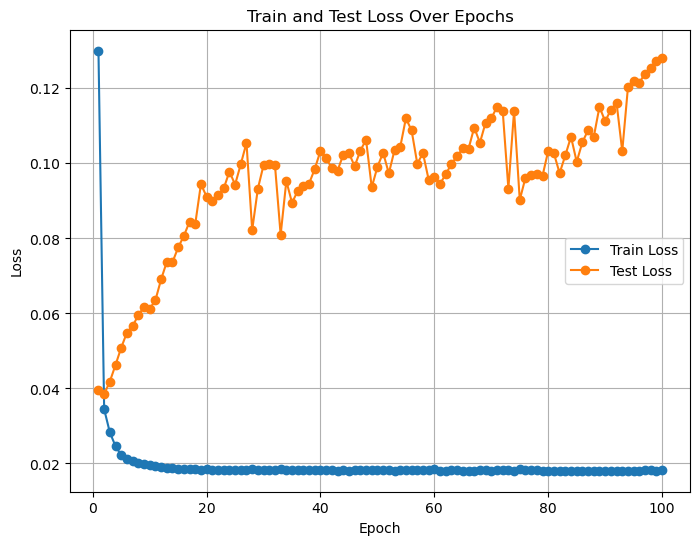

In [10]:

plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs + 1), test_losses, label="Test Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Test Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


#### Build the recommendation function
Now we're getting down to brass tacks...

In [11]:
def recommend_with_nn(query_idx, tfidf_matrix, model, pr_df, top_n=5, device=torch.device('cpu')):
    """
    recommend the most similar issues using the trained neural network model.
    
    parameters:
    - query_idx: index of the query issue
    - tfidf_matrix: tf-idf matrix
    - model: trained neural network model
    - pr_df: dataframe of the dataset
    - top_n: number of top recommendations to return

    returns:
    - list of tuples (index, predicted similarity, title)
    """
    # move model to the selected device
    model = model.to(device)

    query_vector = torch.tensor(
                                tfidf_matrix[query_idx].toarray(), 
                                dtype=torch.float32
                                ).flatten().to(device)
                                

    similarities = []
    model.eval()                # set the model to evaluation mode
    with torch.no_grad():
        for idx in range(tfidf_matrix.shape[0]):
            if idx != query_idx:
                candidate_vector = torch.tensor(tfidf_matrix[idx].toarray(), dtype=torch.float32).flatten().to(device)
                pair_vector = torch.cat([query_vector, candidate_vector], dim = 0).to(device)
                pred_sim = model(pair_vector.unsqueeze(0)).item()
                similarities.append((idx, pred_sim))

    # sort by similarity
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
    return [
        (idx, score, pr_df.iloc[idx]['issue_title_clean'])
        for idx, score in similarities[:top_n]
    ]

# example: recommend similar issues based on the first issue
query_idx = 10  # index of the query issue
recommendations = recommend_with_nn(
    query_idx,
    tfidf_matrix,
    model,
    pr_df,
    top_n = 5,
    device = device
)

for idx, score, title in recommendations:
    print(f'index: {idx}, predicted similarity: {score:.2f}, title: {title}')

index: 36, predicted similarity: 0.14, title: Fix lzw decompression
index: 353, predicted similarity: 0.14, title: Rubyfaraday fix downloadfile
index: 714, predicted similarity: 0.14, title: Fix RTPReceiver getParameters
index: 725, predicted similarity: 0.14, title: Fix WEBVIZURL
index: 814, predicted similarity: 0.14, title: fix synchronization without a datecol


Cool! It is what it is 😁

Let's save the model so we can reuse it in the frontend.

In [15]:
torch.save(model.state_dict(), '../backend/model/model.pth')